# **Presentación**

## Universidad Nacional de Rosario

### **Tecnicatura Universitaria en Inteligencia Artificial**

### IA42 - Procesameinto del Lenguaje Natural

---

**Fecha**: 02/11/2023

**Integrantes**:
- Ferrucci Constantino
- Giampaoli Fabio

**Doncentes**:
- Juan Pablo Manson
- Alan Geary
- Andrea Cavallo
- Ariel D'Alessandro

---

## Resumen

En presente trabajo tiene como finalidad la resolución práctica de ejercicios propuestos por la asignatura `Procesamiento del Lenguaje Natural` con el fin de afianzar los contenidos teoricos prácticos brindados durante el cursado de las primeras tres unidades.

Los ejercicios son de naturaleza continua. Es decir, el desarrollo de un ejercicio requiere la resolcuión de los anteriores. Los mismos consisten principalmente en tareas de procesamiento de texto extraidos de fuentes de noticias de distintas categorias.

Durante el desarrollo del trabajo, se presentan soluciones y problematicas que requieren de soluciones con Web Scraping, depuración de texto, transformaciones vectoriales y entrenamiento y uso de modelos de lenguaje.

# **Entorno**

En este item se pretende generar e importar clases y funciones que seran de utilidad para el desarrollo de los ejercicios.

### Librerias

Para desarrollar las funcionalidades requeridas es necesario hacer uso de distintos paquetes y funciones que ofrece Python para procesar datos y lenguaje.

In [1]:
%%capture
!pip install sentence-transformers transformers

In [2]:
# web scraping
import requests
from bs4 import BeautifulSoup

# visualizaciones
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import clear_output

# procesamiento de datos
import pandas as pd
import re
from random import choice

# modelos de lenguaje
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# otros modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# depuracion de datos
from nltk.corpus import stopwords

### Configuración inicial

Las siguientes líneas de código logran establecer configuraciones iniciales que seran de utilidad para el transcurso de todo el trabajo.

In [3]:
nltk.download('stopwords') # descarga de stopwords
pd.set_option('display.max_colwidth', None)  # Esto muestra el máximo de anchura de una columna de un dataframe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Definición de clases

La siguiente clase se define con el fin facilitar la obtención y tratamiento de la información obtenida de las paginas web.

In [4]:
class Noticia:
  def __init__(self, titulo, texto, url):
    # define la estructura de las noticias
    self.titulo = titulo
    self.texto = texto
    self.url = url

  def get_titulo(self):
    return self.titulo

  def get_texto(self):
    return self.texto

  def get_url(self):
    return self.url

  def __str__(self):
    # impresión amigable del objeto, muestra sus propiedades de forma ordenada
    noticia = f'{self.titulo} - ({self.url})\n\n{self.texto}'
    return noticia

La siguiente clase tiene la intención de generar metodos que permitan manipular el conjunto de noticias obtenidas para cada clase.

In [5]:
class Categoria:
  def __init__(self, categoria, url, id):
    # estructura de una categoria
    self.categoria = categoria
    self.url = url
    self.id = id
    self.noticias = []
    self.url_principal = url[: url.index('.com') + 4]

  def set_noticias(self, noticias):
    # almacenar las noticias en el objeto
    self.noticias = noticias

  def add_noticia(self, noticia):
    # añadir una nueva
    self.noticias.append(noticia)

  def get_noticias(self):
    return self.noticias

  def get_noticia(self, num_index):
    return self.noticias[num_index]

  def __str__(self):
    # formato de impresión ordenado de las noticias de una categoria
    if len(self.noticias) == 0:
      return 'No hay noticias cargadas.'
    texto = ''
    for i, noticia in enumerate(self.noticias):
      texto += f'{i + 1} - {noticia.get_titulo()} ({noticia.get_url()})\n'
    return texto

### Definición de funciones

In [6]:
def find_noticia(categoria, class_=None, label=None):
  args = {'class_': class_} if class_ else {'name': label}
  request = requests.get(categoria.url).text
  soup = BeautifulSoup(request, 'html')
  urls_noticias = []

  for etiqueta in soup.find_all(**args)[:10]:
    while etiqueta and etiqueta.name != 'a':
      etiqueta = etiqueta.parent
    urls_noticias.append(categoria.url_principal + etiqueta.get('href'))
  noticias = []

  for url_noticia in urls_noticias:
    request_noticia = requests.get(url_noticia).text
    soup_noticia = BeautifulSoup(request_noticia, 'html')
    titulo = soup_noticia.find_all('h1')[0].text
    texto = '\n'.join([p.text for i, p in enumerate(soup_noticia.find_all('p')[1:]) if not p.text.startswith('Por ') or i != 0])
    noticia = Noticia(titulo, texto, url_noticia)
    noticias.append(noticia)

  categoria.set_noticias(noticias)
  return None


def plot_custom_histogram(data, bins=10, title="Histograma", x_label="Valores", y_label="Frecuencia",
                          color='royalblue', edgecolor='black', alpha=0.7, grid=True, figsize=(8, 6)):
  """
  Crea un histograma personalizado a partir de una lista de datos.
  args:
    data: Lista de datos para el histograma.
    bins: Número de contenedores (bins) para el histograma (por defecto, 10).
    title: Título del gráfico.
    x_label: Etiqueta del eje x.
    y_label: Etiqueta del eje y.
    color: Color de las barras del histograma.
    edgecolor: Color del borde de las barras.
    alpha: Transparencia de las barras (0.0 - 1.0).
    grid: Mostrar cuadrícula en el gráfico.
    figsize: Tamaño de la figura (ancho, alto).
  returns:
    None
  """
  plt.figure(figsize=figsize)
  plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
  plt.title(title, fontsize=16)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

  if grid:
      plt.grid(True, linestyle='--', alpha=0.7)

  plt.show()


def extract_category_labels(categories_list):
  labels = {categoria.id: categoria.categoria for categoria in categorias}
  return labels


def give_labels_to_data(categorias):
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append((categoria.id, noticia.titulo))
  # data = [(categoria.id, noticia.titulo) for noticia in categoria.get_noticias() for categoria in categorias]
  return data


def extract_longitud_noticias(categorias):
  # valores = [len(noticia.texto) for noticia in categoria.get_noticias() for categoria in categorias]
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append(len(noticia.texto))
  return data


def split_values(data):
  X = [text.lower() for label, text in data]
  y = [label for label, text in data]
  return X, y


def preprocess_text(text):
  stop_words = stopwords.words('spanish')
  text = text.lower()
  text = ''.join([c for c in text if c.isalnum() or c.isspace()])
  words = text.split()
  words = [word for word in words if word not in stop_words]
  return ' '.join(words)


def extract_text_from_noticias(categorias):
  noticias = {categoria.id: [noticia.get_texto() for noticia in categoria.get_noticias()] for categoria in categorias}
  return noticias


def extract_preprocessed_text_from_noticias(categorias):
  noticias = {categoria.id: [preprocess_text(noticia.get_texto()) for noticia in categoria.get_noticias()] for categoria in categorias}
  return noticias


def graficar_nube_palabras(noticias):
  for category, preprocessed_texts in noticias.items():

    # Conteo de palabras en la categoría
    vectorizer = CountVectorizer()
    word_counts = vectorizer.fit_transform(preprocessed_texts)

    # Crea una nube de palabras para la categoría
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vectorizer.vocabulary_)

    # Muestra la nube de palabras de la categoría
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Categoria: {labels[category]}')
    plt.show()


def get_similarity_cos_df(puntuaciones):
  pares = []
  for i in range(len(puntuaciones)-1):
    for j in range(i+1, len(puntuaciones)):
      pares.append({'index': [i, j], 'score': puntuaciones[i][j]})

  # Ordenamos las puntuaciones en orden decreciente
  pares = sorted(pares, key=lambda x: x['score'], reverse=True)
  tabla = []
  # Añadimos las filas a la tabla
  for par in pares[0:10]:
    i, j = par['index']
    tabla.append([noticias_deportes[i], noticias_deportes[j], f"{par['score']:.4f}"])
  columnas = ['Titulo 1', 'Titulo 2', 'Puntuación']
  tabla

  df = pd.DataFrame(tabla, columns=columnas)
  return df


def summarize_new(model, tokenizer, new):
  WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

  input_ids = tokenizer(
      [WHITESPACE_HANDLER(new)],
      return_tensors="pt",
      padding="max_length",
      truncation=True,
      max_length=512
  )["input_ids"]

  output_ids = model.generate(
      input_ids=input_ids,
      max_length=84,
      no_repeat_ngram_size=2,
      num_beams=4
  )[0]

  summary = tokenizer.decode(
      output_ids,
      skip_special_tokens=True,
      clean_up_tokenization_spaces=False
  )

  return summary

# **Ejercicios**

Contamos con cinco ejercicios en total. En cada desplegable de detalla en el uniciado de cada uno, su desarrollo y sus concluciones individuales.

Es importante considerar que los ejercicios son dependientes entre si, por lo que se recomienda enternderlos y replicarlos de forma ordenada.

### *Primer ejercicio*  

---

Construir un dataset haciendo web scraping de páginas web de su elección.

- Definir 4 categorías de noticias/artículos.
- Para cada categoría, extraer los siguientes datos de 10 noticias diferentes:
- url (sitio web donde se publicó el artículo)
- título (título del artículo)
- texto (contenido del artículo)

Utilizando los datos obtenidos construya el dataset en formato csv.

---

#### Obtención de noticias

En la siguiente celda se inicializan las clases de categorias, cada una con sus atributos de Nombre, Url y Id.

Se elijieron las categorias mostradas debajo. De cada categoria se encuentra en internet la url de las paginas de disitntas fuentes que almacenan noticias correspondientes a cada categoria.

In [7]:
politica = Categoria('Politica', 'https://infobae.com/politica/', 0)
deporte = Categoria('Deporte', 'https://www.infobae.com/america/deportes/espn/', 1)
pelicula = Categoria('Pelicula', 'https://www.infobae.com/tag/peliculas/', 2)
tecnologia = Categoria('Tecnologia', 'https://www.infobae.com/tag/perfiles-tecno/', 3)

categorias = [politica, deporte, pelicula, tecnologia]

Se define una función externa cuya utilidad es la de hacer consultas a la web de una categoria dada.

A la consulta se le pasa por parametro la clase del elemnto que distingue a cada noticia en particular. Mediante investigación con las herramientas de desarrollador del motor de busqueda, se encuentra que cada fuente indentifica las noticias con una clase en particular.

Tambien es posible buscar mediante etiquetas los objetos que indentifican a cada noticia en la pagina web.



In [8]:
def find_noticia(categoria, class_=None, label=None):
    # toma la etiqueta o la clase de cada noticia
    args = {'class_': class_} if class_ else {'name': label}

    # abre la consulta a la web
    request = requests.get(categoria.url).text
    soup = BeautifulSoup(request, 'html')

    # se almacena la url de cada noticia particular
    urls_noticias = []

    for etiqueta in soup.find_all(**args)[:10]: # se filtran solo las primeras 10 noticias
        while etiqueta and etiqueta.name != 'a': # de cada noticia se recorre la estructura para encontrar su link
            etiqueta = etiqueta.parent
        urls_noticias.append(categoria.url_principal + etiqueta.get('href'))

    # se almacena de cada noticia su contenido y otras propiedades de las mismas en el objeto correspondiente
    noticias = []

    for url_noticia in urls_noticias:
        # consulta al url de la noticia particular
        request_noticia = requests.get(url_noticia).text
        soup_noticia = BeautifulSoup(request_noticia, 'html')
        # extraccion de atributos
        titulo = soup_noticia.find_all('h1')[0].text
        texto = '\n'.join([p.text for i, p in enumerate(soup_noticia.find_all('p')[1:]) if not p.text.startswith('Por ') or i != 0])
        noticia = Noticia(titulo, texto, url_noticia)
        # almacenamiento en memoria
        noticias.append(noticia)

    # almacenamiento en el objeto categoria
    categoria.set_noticias(noticias)
    return None

De esta manera, una vez que se conocen las clases que indetifican a cada noticia de la url general, podemos aplicar esta funcion para cargar en memoria las 10 noticias correspondientes a cada categoria.

Notar que en este caso la clase para la segunda categoria es distinta a las demas debido a que cambia la fuente de origen, por lo que la estructura de la pagina es distinta.

In [9]:
find_noticia(politica, 'feed-list-card-headline-lean')
find_noticia(deporte, 'story-card-hl')
find_noticia(pelicula, 'feed-list-card-headline-lean')
find_noticia(tecnologia, 'feed-list-card-headline-lean')

#### Visualización

En la siguiente celda desplegable se puede visualizar que se han cargado correctamente todas las noticas de cada categoria.

In [10]:
# Todas las noticias de cada categoria
for categoria in categorias:
  print(f'Noticias de {categoria.categoria} ({categoria.url})')
  print(categoria)

Noticias de Politica (https://infobae.com/politica/)
1 - Elecciones 2023, en vivo: “Perdimos por paliza, tuvimos una pésima candidata y una pésima campaña”, aseguró un exministro de Mauricio Macri (https://infobae.com/politica/2023/10/29/elecciones-2023-en-vivo-todas-las-noticias-rumbo-al-balotaje-minuto-a-minuto/)
2 - Macri volverá a hablar este domingo, se consolida el pacto con Milei y se rompe más una oposición rota (https://infobae.com/politica/2023/10/29/macri-volvera-a-hablar-este-domingo-se-consolida-el-pacto-con-milei-y-se-rompe-mas-una-oposicion-rota/)
3 - Jaime Durán Barba: “Supongo yo que Macri no habrá leído el programa de Milei” (https://infobae.com/politica/2023/10/29/jaime-duran-barba-supongo-yo-que-macri-no-habra-leido-el-programa-de-milei/)
4 - Dos diputados que apoyaron a Juan Schiaretti confirmaron que votarán por Massa: “No podemos ser neutrales” (https://infobae.com/politica/2023/10/29/dos-diputados-que-apoyaron-a-juan-schiaretti-confirmaron-que-votaran-por-massa-

In [11]:
# ejemplo del contenido de una noticia
print(tecnologia.get_noticia(1))

Cómo triunfar en Youtube: Alejandro Gowland, líder de Creative Works de Google, reveló el secreto - (https://www.infobae.com/tecno/2023/10/06/es-clave-que-las-marcas-conecten-con-su-publico-a-traves-de-youtube-shorts/)

En un mar de contenido en línea, la creatividad permite destacar y diferenciarse de otros. Con esa premisa entrevistamos a Alejandro Gowland, director de Creative Works de Google para Hispanoamérica, quien habló con Infobae en exclusiva sobre la importancia de que una idea conecte con la audiencia. 
Asimismo, es importante que esa idea tenga la posibilidad de expandirse, para que pueda sostenerse a largo plazo o al menos por un período de tiempo razonable. “No hay que quedarse siempre con lo mismo”, subraya el ejecutivo de Google.
Gowland añade que es fundamental conocer a la audiencia y saber cómo se comporta: “hay un estudio interesante que nos cuenta que nuestro consumo en YouTube, en promedio, es de 15 verticales de contenido, es decir, a mí no solo me gusta el teni

La siguiente función tiene propocito de generar un historigrama de utilidad para dar una intuición de las longitudes de las noticias.

In [12]:
def plot_custom_histogram(data, bins=15, title="Histograma", x_label="Valores", y_label="Frecuencia", color='skyblue', edgecolor='black', alpha=0.7, grid=True, figsize=(14, 6)):
  plt.figure(figsize=figsize)
  plt.hist(data, bins=bins, color=color, edgecolor=edgecolor, alpha=alpha)
  plt.title(title, fontsize=16)
  plt.xlabel(x_label, fontsize=12)
  plt.ylabel(y_label, fontsize=12)

  if grid:
      plt.grid(True, linestyle='--', alpha=0.7)

  plt.show()

La siguiente función tiene proposito de extraer la longitud de cada noticia de cada categoria y almacenarla en una lista.

In [13]:
def extract_longitud_noticias(categorias):
  # valores = [len(noticia.texto) for noticia in categoria.get_noticias() for categoria in categorias]
  data = []
  for categoria in categorias:
    for noticia in categoria.get_noticias():
      data.append(len(noticia.texto)) # longitud de una noticia
  return data

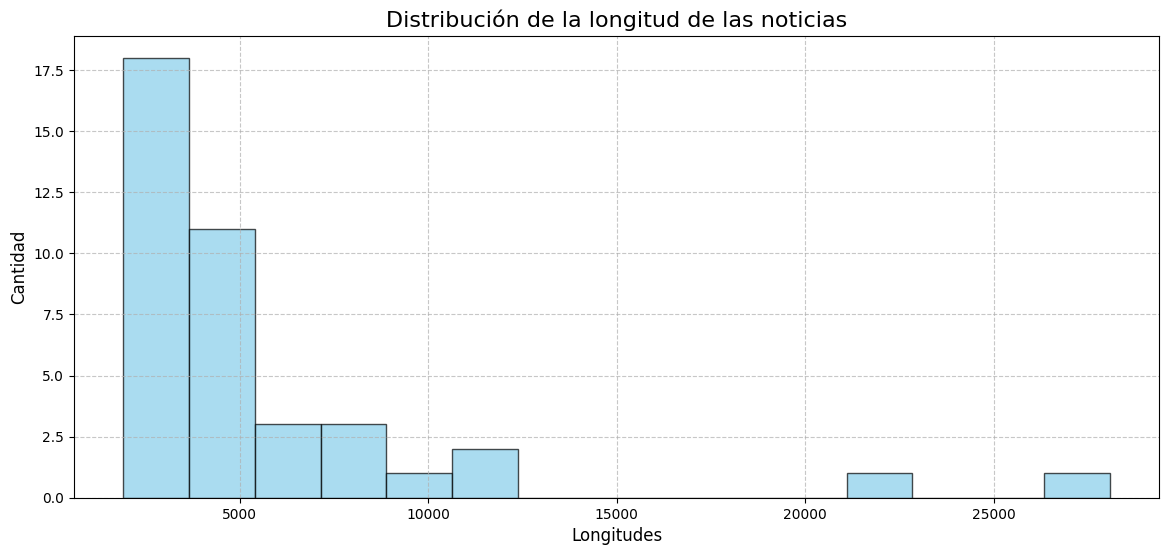

In [14]:
valores = extract_longitud_noticias(categorias) # metodo de obtencion de longitudes

plot_custom_histogram(valores, title="Distribución de la longitud de las noticias", x_label="Longitudes", y_label="Cantidad")

Este grafico sugiere que las longitudes de las noticias son mas comunes entres 2500 y 5000 caracteres.

#### Formato tabular

### *Segundo ejercicio*

#### Guardamos las etiquetas y los datos etiquetados

In [15]:
labels = extract_category_labels(categorias)
labels

{0: 'Politica', 1: 'Deporte', 2: 'Pelicula', 3: 'Tecnologia'}

In [16]:
data = give_labels_to_data(categorias)
print('Longitud de datos:', len(data))
print('Primer registro:', data[0])

Longitud de datos: 40
Primer registro: (0, 'Elecciones 2023, en vivo: “Perdimos por paliza, tuvimos una pésima candidata y una pésima campaña”, aseguró un exministro de Mauricio Macri')


#### Dividimos los datos en X e Y

In [17]:
X, y = split_values(data)

#### Seleccionamos los datos de entrenamiento

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

#### Creamos el vectorizador

In [19]:
spanish_stop_words = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words)

#### Vectorizamos los datos de entrenamiento y testeo

In [20]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

#### Creamos el modelo de categorizacion

In [21]:
model = LogisticRegression(max_iter=10000)

#### Entrenamos el modelo

In [22]:
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=10000)

#### Testeamos el modelo y vemos métricas para saber su precisión y error

In [23]:
y_pred_LR = model.predict(X_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1, output_dict=True)
df_report_LR = pd.DataFrame(report_LR).transpose()

print("Precisión Regresión Logística:", acc_LR)
print("\nReporte de clasificación Regresión Logística:")
display(df_report_LR)

Precisión Regresión Logística: 0.875

Reporte de clasificación Regresión Logística:


,precision,recall,f1-score,support
0,0.5000,1.000,0.666667,1.000
1,1.0000,1.000,1.000000,2.000
2,1.0000,0.500,0.666667,2.000
3,1.0000,1.000,1.000000,3.000
accuracy,0.8750,0.875,0.875000,0.875
macro avg,0.8750,0.875,0.833333,8.000
weighted avg,0.9375,0.875,0.875000,8.000


### *Tercer ejercicio*

#### Aplicamos un preprocesamiento a los textos de las noticias

In [24]:
noticias = extract_preprocessed_text_from_noticias(categorias)

#### Visualizamos cuales son las palabras que más se repiten

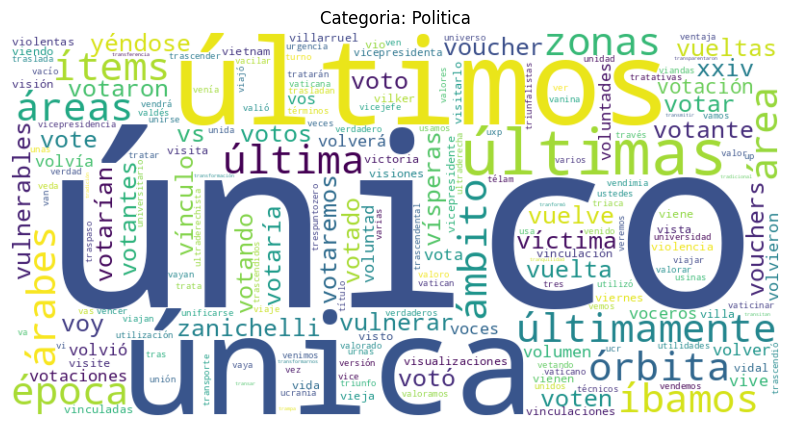

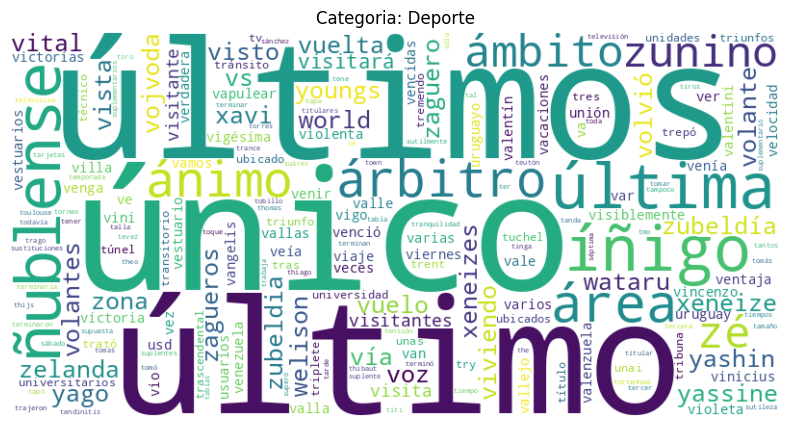

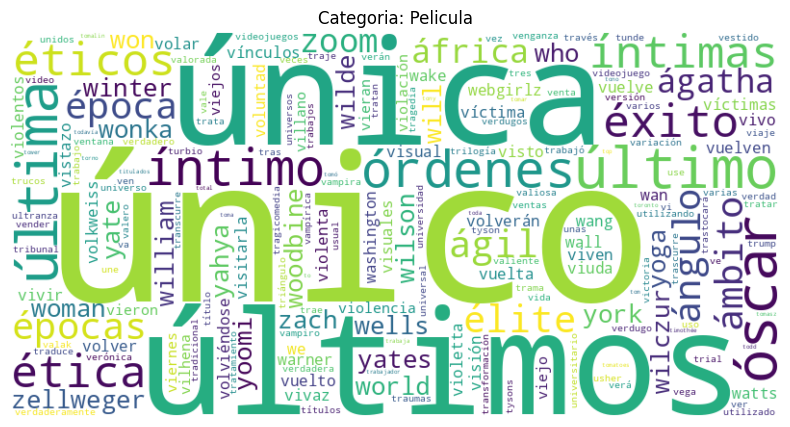

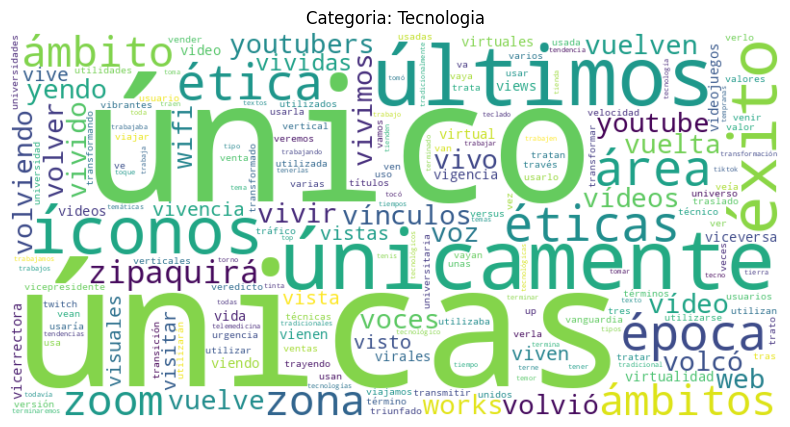

In [25]:
graficar_nube_palabras(noticias)

### *Cuarto ejercicio*

#### Inicializamos el modelo

In [26]:
modelo = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#### Elegimos la categoria y aplicamos embedding a los titulos de las noticias de esa categoria

In [27]:
noticias_deportes = [noticia.titulo for noticia in deporte.get_noticias()]
embeddings = modelo.encode(noticias_deportes, convert_to_tensor=True)

#### Calculamos la similitud de coseno entre los títulos

In [28]:
puntuaciones_coseno = util.cos_sim(embeddings, embeddings)

#### Pasamos las puntuaciones a dataframe y vemos las mejores similitudes

In [29]:
df_simil_cos = get_similarity_cos_df(puntuaciones_coseno)
df_simil_cos.head()

,Titulo 1,Titulo 2,Puntuación
0,El try de Los Pumas que generó indignación en Inglaterra: “Parecía fútbol americano”,Del festejo al lamento: el minuto fatal de Los Pumas ante Inglaterra por el tercer puesto del Mundial de rugby,0.6404
1,Liga de Quito venció por penales a Fortaleza y se consagró campeón de la Copa Sudamericana,Lucas Beltrán rompió su sequía en Europa con dos golazos para la victoria de la Fiorentina en la Conference League,0.4769
2,El curioso blooper de Darwin Núñez en el triunfo del Liverpool: falló con el arco vacío y tuvo una extraña reacción cuando la jugada terminó en gol,Lucas Beltrán rompió su sequía en Europa con dos golazos para la victoria de la Fiorentina en la Conference League,0.4602
3,Candidato a gol del año: Harry Kane hizo historia al anotar desde atrás de mitad de cancha en el 8-0 del Bayern Múnich,El curioso blooper de Darwin Núñez en el triunfo del Liverpool: falló con el arco vacío y tuvo una extraña reacción cuando la jugada terminó en gol,0.4416
4,Las perlitas del empate de Boca: del susto por el pisotón a Valentín Barco al gesto de Almirón a la gente de cara a la Libertadores,"Un grave error defensivo, el cruce Xavi-Vinicius y el doblete consagratorio de Bellingham: las perlitas del Barcelona-Real Madrid",0.4297


### *Quinto ejercicio*

#### Elección del modelo que se encargue de resumir las noticias

In [30]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
summarize_model = AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### Control interactivo

In [ ]:
while True:
  print('Selecciona una categoria:\n1- Politica\n2- Deporte\n3- Pelicula\n4- Tecnologia\n\n9- Salir\n')
  category = None

  while True:
      category = input('>>> ')

      if category not in ["1", "2", "3", "4", "9"]:
        print('Elije una opción dada')
        continue

      break

  if category == "9":
    break

  clear_output()

  category = int(category) - 1
  print(f'Resumiendo una noticia de la categoria {labels[category]}\n')

  noticia = choice(categorias[category].get_noticias())
  titulo = noticia.titulo
  texto = noticia.texto

  resumen = summarize_new(summarize_model, tokenizer, texto)
  print('Titulo:', titulo)
  print(resumen)

  input('\nENTER PARA CONTINUAR\n')
  clear_output()
clear_output()
print('Programa finalizado')

Selecciona una categoria:
1- Politica
2- Deporte
3- Pelicula
4- Tecnologia

9- Salir



# **Concluciones**
